# GEOtiled Mosaic Optimization Notebook

<p style="text-align:center">
    <img src="images/mosaic_optimization.png" width="800"/>
</p>
<p style="text-align:center">
    <b>Figure 1. </b>Mosaic Optimization
</p>

This notebook showcases the execution time improvements made by changes to how GEOtiled mosaics tiles together.

## Preconfiguration

Import the needed libraries to run the code blocks.

In [1]:
import crop_functions as cp
import mosaic_functions as ms
import geotiled
import time

Modify the testing parameters below to change the data and size of tiles created. 

Do not specify tile sizes that would cause the final file count to exceed the number of cores available for the best performance results.

In [2]:
# The working directory to store files in
working_directory = '/media/volume/geotiled-saga/mosaic_test'
geotiled.set_working_directory(working_directory)

# Size of tiles to produce specified as a list of [x,y] values (units of pixels)
tile_sizes = [[18274,16862],[18274,8431],[9137,8431],[9137,4216],[4569,4216]]

# Data to download
resolution = '30m'
region = 'TN'

# Number of runs to do (execution times for each tile size will be averaged at the end)
runs = 1

Create a CSV to store the results to.

In [8]:
file = open('results.csv', 'w')
file.write('method,tile_size,run_number,execution_time\n')
file.close()

## Initialization

Download and preprocess the data.

In [9]:
# Download the desired data
geotiled.fetch_dem(shapefile=region, dataset=resolution, save_to_txt=False, download=True)

# Mosaic DEMs
geotiled.build_mosaic(input_folder='dem_tiles', output_file='mosaic.tif', description='Elevation')

# Reproject mosaic into computable format
geotiled.reproject(input_file='mosaic.tif', output_file='elevation.tif', projection='EPSG:26918')

Downloading: 100%|█████████████████████████████████████████████| 58.1M/58.1M [00:02<00:00, 24.6MB/s]
Downloading: 100%|█████████████████████████████████████████████| 1.72G/1.72G [00:18<00:00, 93.7MB/s]


Crop file into each of the specified tile sizes.

In [10]:
for ts in tile_sizes:
    cp.parallel_crop('elevation.tif', f"{ts[0]}x{ts[1]}_tiles", ts[0], ts[1])

## Mosaic via Averaging

Mosaic using the old method of averaging together buffer regions.

In [11]:
for ts in tile_sizes:
    for i in range(runs):
        # Perform moasic
        start_time = time.time()
        ms.mosaic_average(f"{ts[0]}x{ts[1]}_tiles", 'average_mosaic.tif')
        run_time = time.time() - start_time

        # Update CSV
        file = open('results.csv', 'a')
        file.write(f"averaging,{ts[0]}x{ts[1]},{i},{run_time}\n")
        file.close()

## Mosaic via Crop and Concatentation

Mosaic using the new method of cropping the buffer region and concatenating tiles together.

In [12]:
for ts in tile_sizes:
    for i in range(runs):
        # Perform moasic
        start_time = time.time()
        ms.mosaic_concat(f"{ts[0]}x{ts[1]}_tiles", 'concat_mosaic.tif')
        run_time = time.time() - start_time

        # Update CSV
        file = open('results.csv', 'a')
        file.write(f"concatenation,{ts[0]}x{ts[1]},{i},{run_time}\n")
        file.close()

## Visualize Results

Plot execution time of both mosaic procedures.

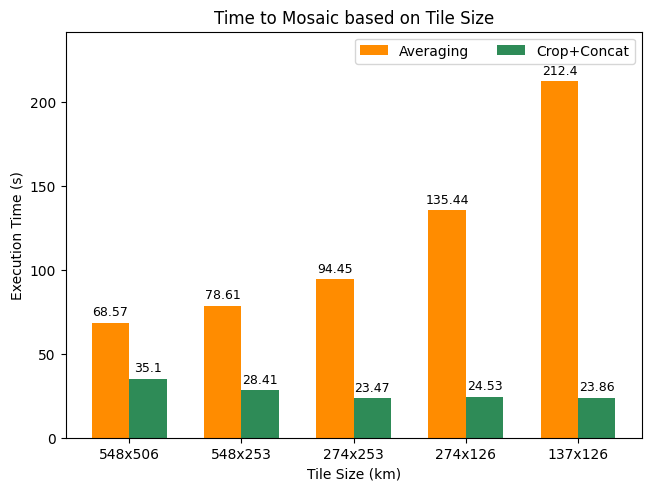

In [3]:
ms.plot_mosaic_results('results.csv')

### End of Notebook